In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs

params torch.Size([1800, 4])


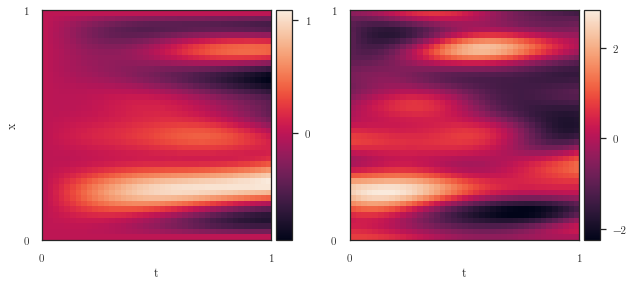

In [10]:
ntest = 50

dataset = ReactionDiffusion('../../data', nn_format=True, max_n=4000, ntest=ntest)

i = 3
tx = dataset.data[i][0]
lf = dataset.data[i][1]
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [
        tx[:, :, 0].t(),
        lf[:, :, 0].t(),
    ],
    extent, nrows=1, ncols=2
)

batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

params torch.Size([50, 4])
params torch.Size([50, 4])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


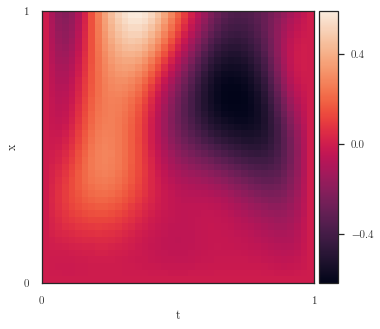

In [11]:
dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 8
width = 32
in_channels = 3

In [15]:
ode_data = False
if ode_data:
    width = 20
    modes = 4
    in_channels = 11
    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                              batch_size=ntest, shuffle=True)
    num_outputs = 10
    datasets = list()
    for i in range(2):
        basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
        sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
        decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)

        dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
        datasets.append(dataset)
    ntrain=2


    print(x_train.shape)

In [16]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

7087726


In [ ]:
trainer.train(10);

Epoch 001/010 - Loss: 0.55 (0.51 0.50 0.48 0.05 0.02)
Epoch 002/010 - Loss: 0.47 (0.36 0.45 0.34 0.01 0.02)


In [12]:
def show_result(model, loader):
    x, y, params = next(iter(loader))
    out, params_out = model(x)

    if block_dim == 1:
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(x[0, :, i])#.shape, y.shape)
        axes[1].plot(y[0, :, 0])
        axes[1].plot(out[0, :, 0].detach())
    else:
        num_t = x.shape[1]
        num_x = x.shape[2]
        print(num_t, num_x)
        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x).t(),
                y[0, ..., 0].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )
        out = out.squeeze()
        y_target = y.squeeze()
        print(params_out[0].detach(), params[0])
        print(F.mse_loss(out[...,0], y_target))
        # from lafomo.utilities.torch import smse, q2
        # print(y.shape, f_mean_test.shape)
        # print(smse(y_target, f_mean_test).shape)


41 41
tensor([0.1742, 0.2772, 0.2035, 0.0260]) tensor([0.1000, 0.4000, 0.0100, 0.0505])
tensor(0.1152, grad_fn=<MseLossBackward>)


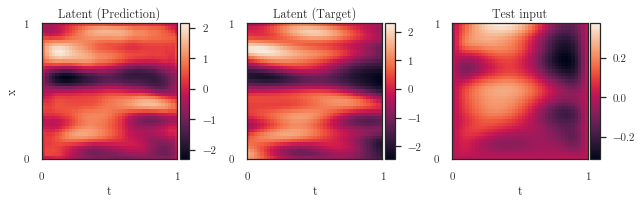

In [13]:
show_result(model, train_loader)

41 41
tensor([0.1878, 0.2787, 0.2015, 0.0240]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.1175, grad_fn=<MseLossBackward>)
81 81
tensor([ 1.3393,  1.1261,  0.7381, -0.1340]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.1152, grad_fn=<MseLossBackward>)


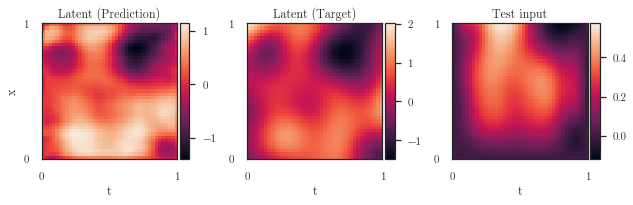

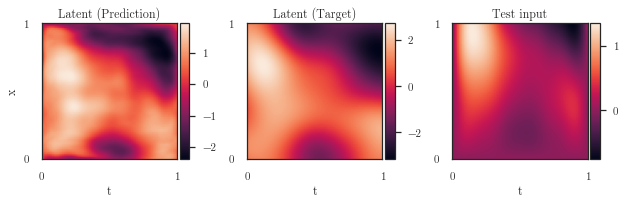

In [14]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

torch.Size([2, 512]) torch.Size([1, 4, 512]) torch.Size([1, 4])
params torch.Size([1, 4])
torch.Size([8, 64, 3])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


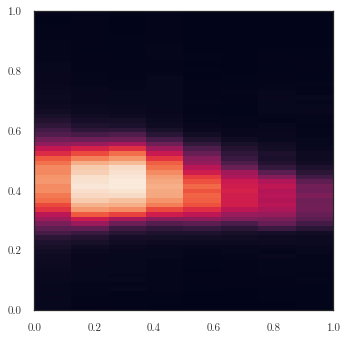

In [41]:
from lafomo.datasets import DrosophilaSpatialTranscriptomics

dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../data', scale=True, nn_format=True)

dataset.train_data[0] = (
    dataset.train_data[0][0],#.permute(1, 0, 2),
    dataset.train_data[0][1],
    dataset.train_data[0][2]
)
print(dataset.train_data[0][0].shape)
dros_loader = DataLoader(dataset.train_data)
plt.imshow(dataset.train_data[0][1][:, :, 0].t(), origin='lower', extent=extent)

In [44]:
print('shaep', dros_loader.dataset[0][1].shape)
print(dros_loader.dataset[0][0].shape)
from sklearn.preprocessing import MinMaxScaler
# from os import path
# import pandas as pd
# indents = {'kr': 64, 'kni': 56, 'gt': 60}
# gene = 'kr'
# assert gene in indents
# data = pd.read_csv(path.join('../../data', f'clean_{gene}.csv'))
# data = data.iloc[indents[gene]:].values
# data = data[:, [0, 1, 3, 2]]

# print(data.shape)
# scaler = MinMaxScaler()
# data[:, 0:1] = scaler.fit_transform(data[:, 0:1])
# data[:, 1:2] = scaler.fit_transform(data[:, 1:2])

shaep torch.Size([8, 64, 1])
torch.Size([8, 64, 3])


8 64
tensor([0.1948, 0.9098, 0.8720, 0.5505]) tensor([-1., -1., -1., -1.])
tensor(0.5571, grad_fn=<MseLossBackward>)


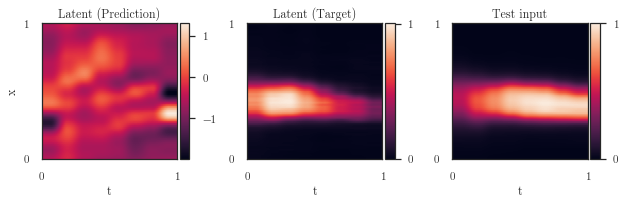

In [45]:
show_result(model, dros_loader)

48
50
torch.Size([81, 81, 3])


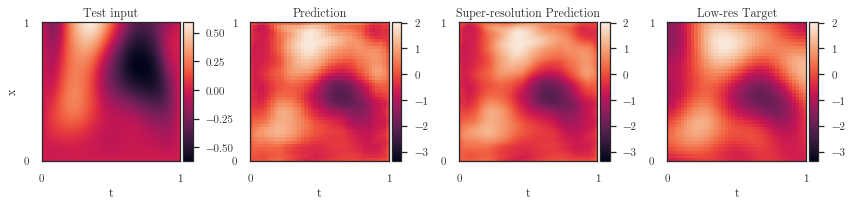

In [50]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)

x_sub, y_sub, params_sub = subsampled_loader.dataset[i]
x, y, params = high_res_loader.dataset[i]
out, _ = model(x.unsqueeze(0))
out_sub, _ = model(x_sub.unsqueeze(0))

num_t = x.shape[0]
num_x = x.shape[1]
num_t_sub = x_sub.shape[0]
num_x_sub = x_sub.shape[1]

plot_spatiotemporal_data(
    [
        x[..., 0].view(num_t, num_x).t(),
        out_sub[0, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[0, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[...,0].min(), x[...,0].max())] + [(out[0].min(), out[0].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
# plt.savefig('toy48.pdf', **tight_kwargs)

torch.Size([2, 1681]) torch.Size([1, 4, 1681]) torch.Size([1, 4])
params torch.Size([1, 4])
torch.Size([41, 41, 3])
41 41
tensor([0.1769, 0.2779, 0.2035, 0.0256]) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.0837, grad_fn=<MseLossBackward>)
torch.Size([41, 41, 1])
torch.Size([1, 4, 1681])
torch.Size([1, 1681])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s1, s2, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s1, s2, 4), dtype=torch.float)


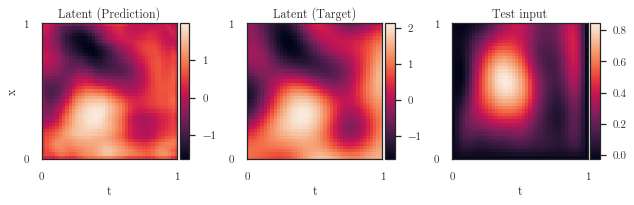

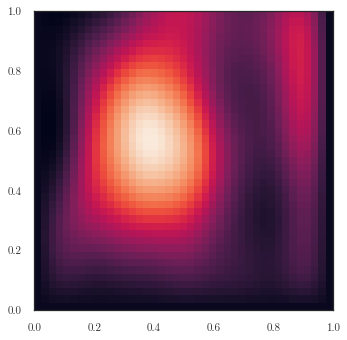

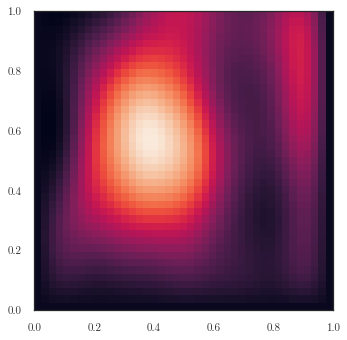

In [62]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True, nn_format=True, ntest=0)
print(dataset.train_data[0][0].shape)

toy_loader = DataLoader(dataset.train_data)
show_result(model, toy_loader)
print(dataset[0][1].shape)
print(dataset.orig_data.shape)
plt.figure()
d = dataset.train_data[0][0][:, :, 0]
x = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
print(x[0][1].shape)
plt.imshow(x[0][1][0].view(41, 41).t(), origin='lower', extent=extent)
plt.figure()
plt.imshow(d.t(), origin='lower', extent=extent)

In [65]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=True)
data = next(iter(dataset))
data_input, y = data
tx, y_target = data_input, y
print(tx.shape, y_target.shape)
# 1. Ensure that time axis must be in ascending order:
# We use mergesort to maintain relative order
t_sorted = np.argsort(tx[0, :], kind='mergesort')
print(t_sorted)
tx = tx[:, t_sorted]
y_target = y_target[:, self.t_sorted]

# 2. Discretise time
if hasattr(dataset, 'num_discretised'):
    num_discretised = dataset.num_discretised
else:
    num_discretised = 40
time = discretise(tx[0, :], num_discretised=num_discretised)
time = torch.tensor(time)
# 3. Discretise space
spatial_grid = self.discretise_spatial(tx)
spatial = torch.tensor(spatial_grid)

# 4. Reconstruct dataset
new_t = time.repeat(spatial.shape[0], 1).transpose(0, 1).reshape(-1)
t_mask = new_t == tx[0, :]

new_x = spatial.repeat(time.shape[0])
x_mask = new_x == tx[1, :]

mask = torch.stack([t_mask, x_mask])
self.tx = torch.stack([new_t, new_x])
self.y_target = y_target

torch.Size([2, 1681]) torch.Size([1, 1681])
tensor([   0,   41,   82,  ..., 1598, 1639, 1680])


NameError: name 'self' is not defined

torch.Size([41, 41, 3]) torch.Size([41, 41, 1])


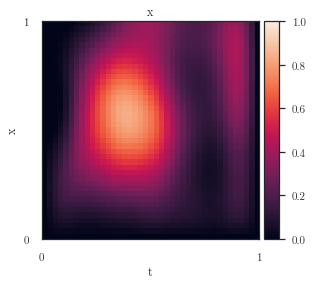

In [47]:
x, y, _ = toy_loader.dataset[0]
i = 0
# out, _ = model(x)
# out_sub, _ = model(x_sub)
num_t = x.shape[0]
num_x = x.shape[1]
print(x.shape, y.shape)
plot_spatiotemporal_data(
    [
        x[..., 0].view(41, 41).t(),
        # out[i, ..., 0].detach().view(num_t, num_x).t(),
        # y[i, ..., 0].view(41, 41).t(),
    ],
    extent, nrows=1, ncols=1, figsize=(12, 4),
    clim=[(x[...,2].min(), x[...,2].max())],#, (y[i,...,0].min(), y[i,...,0].max())],
    titles=['x', 'y']
)

In [ ]:
data = dataset.orig_data
print(data.shape)
plt.imshow(data[0, 2].view(41, 41))

In [ ]:
torch.save(model.state_dict(), './saved_model0205.pt')

In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

In [ ]:
weight = torch.rand((width, width, modes, modes))
x_ft = torch.rand((10, width, 41, 21))
out_ft = torch.rand((10, width, 41, 21))
print('weight', weight.shape)
print('x_ft', x_ft.shape)
print('out_ft', out_ft.shape)

In [ ]:
from lafomo.utilities.torch import compl_mul2d
out_ft[:, :, :modes, :modes] = compl_mul2d(
    x_ft[:, :, :modes, :modes], weight
)
first = out_ft.clone()

print(x_ft[:, :, :modes, :modes].shape, weight.permute(1, 0, 2, 3).unsqueeze(0).shape)
out_ft[:, :, :modes, :modes] = torch.matmul(
    x_ft[:, :, :modes, :modes], weight.permute(1, 0, 2, 3)
)
second = out_ft.clone()
print(second.shape)